In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
data_all = np.loadtxt('./data/data.txt').astype(int)

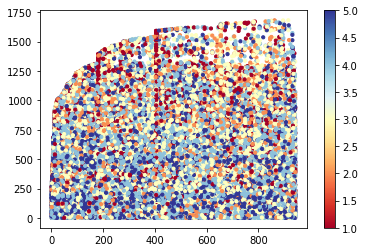

In [10]:
cm = plt.cm.get_cmap('RdYlBu')
plt.figure()
sc = plt.scatter(data_all[:,0], data_all[:,1], c=data_all[:,2], vmin=1, vmax=5, s=10, cmap=cm)
plt.colorbar(sc)

plt.show()

In [90]:
def grad_U(Ui, Yij, Vj, reg, eta, ai = 0, bj = 0):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (reg*np.copy(Ui)-(Yij-np.dot(Ui,Vj)-ai-bj)*Vj)*eta

def grad_V(Vj, Yij, Ui, reg, eta, ai = 0, bj = 0):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (reg*np.copy(Vj) - (Yij-np.dot(Ui,Vj)-ai-bj)*Ui)*eta

def grad_a(Ui, Yij, Vj, reg, eta, ai, bj):
    return (reg*np.copy(ai)-(Yij-np.dot(Ui,Vj)-ai-bj))*eta

def grad_b(Ui, Yij, Vj, reg, eta, ai, bj):
    return (reg*np.copy(bj)-(Yij-np.dot(Ui,Vj)-ai-bj))*eta

def get_err_unbiased(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    Number_data = Y.shape[0]
    squaredloss = np.zeros((Number_data))
    
    for index in range(Number_data):
        err = (Y[index,2]-np.dot(U[Y[index,0]-1,:],V[Y[index,1]-1,:]))**2/2.
        squaredloss[index] = err               
    return np.mean(squaredloss)

def get_err_biased(U, V, Y, a, b, reg=0.0):    
    Number_data = Y.shape[0]
    squaredloss = np.zeros((Number_data))
    
    for index in range(Number_data):
        err = (Y[index,2]-np.dot(U[Y[index,0]-1,:],V[Y[index,1]-1,:])
               -a[Y[index,0]-1]-b[Y[index,1]-1])**2/2.
        squaredloss[index] = err               
    return np.mean(squaredloss)

def train_model_unbiased(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    
    U_current = np.random.uniform(-0.5,0.5,(M,K))
    V_current = np.random.uniform(-0.5,0.5,(N,K))
    err_record = []
    reduc_relative = []
    loss_reduction_init = 0
    err_record.append(get_err_unbiased(U_current,V_current,Y))
    Y_shuffle = np.copy(Y)
    U_new = np.copy(U_current)
    V_new = np.copy(V_current)
    for eindex in range(max_epochs):
        np.random.shuffle(Y_shuffle)
        for dindex in range(Y_shuffle.shape[0]):
            index_ppl = Y_shuffle[dindex,0]
            index_movie = Y_shuffle[dindex,1]
        
            gradu = grad_U(U_new[index_ppl-1,:],Y_shuffle[dindex,2],V_new[index_movie-1,:], 
                       reg, eta)
            U_new[index_ppl-1,:] -= gradu 
            gradv = grad_V(V_new[index_movie-1,:],Y_shuffle[dindex,2],U_new[index_ppl-1,:],
                       reg, eta)
            V_new[index_movie-1,:] -= gradv
            
        err_current = get_err_unbiased(U_current,V_current,Y)
        err_new = get_err_unbiased(U_new,V_new,Y)
        if eindex == 0:
            loss_reduction_init = np.absolute(err_current - err_new)
        U_current = np.copy(U_new)
        V_current = np.copy(V_new)
        err_record.append(err_new)
        reduc_relative.append(np.absolute(err_current - err_new)/loss_reduction_init)
        if eindex > 0:
            if (np.absolute(err_current - err_new)) <= eps*loss_reduction_init:
                break               
    return U_current, V_current, err_new, err_record, reduc_relative

def train_model_biased(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    
    U_current = np.random.uniform(-0.5,0.5,(M,K))
    V_current = np.random.uniform(-0.5,0.5,(N,K))
    a_current = np.random.uniform(-0.5,0.5,(M,1))
    b_current = np.random.uniform(-0.5,0.5,(N,1))
    
    err_record = []
    reduc_relative = []
    loss_reduction_init = 0
    err_record.append(get_err_biased(U_current,V_current,Y,a_current,b_current))
    Y_shuffle = np.copy(Y)
    U_new = np.copy(U_current)
    V_new = np.copy(V_current)
    a_new = np.copy(a_current)
    b_new = np.copy(b_current)
    for eindex in range(max_epochs):
        np.random.shuffle(Y_shuffle)
        for dindex in range(Y_shuffle.shape[0]):
            index_ppl = Y_shuffle[dindex,0]
            index_movie = Y_shuffle[dindex,1]
        
            grada = grad_a(U_new[index_ppl-1,:],Y_shuffle[dindex,2],V_new[index_movie-1,:], 
                       reg, eta,a_new[index_ppl-1],b_new[index_movie-1])
            a_new[index_ppl-1] -= grada
            
            gradb = grad_b(U_new[index_ppl-1,:],Y_shuffle[dindex,2],V_new[index_movie-1,:], 
                       reg, eta,a_new[index_ppl-1],b_new[index_movie-1])
            b_new[index_movie-1] -= gradb
            
            gradu = grad_U(U_new[index_ppl-1,:],Y_shuffle[dindex,2],V_new[index_movie-1,:], 
                       reg, eta,a_new[index_ppl-1],b_new[index_movie-1])
            U_new[index_ppl-1,:] -= gradu 
            
            gradv = grad_V(V_new[index_movie-1,:],Y_shuffle[dindex,2],U_new[index_ppl-1,:],
                       reg, eta,a_new[index_ppl-1],b_new[index_movie-1])
            V_new[index_movie-1,:] -= gradv
            
        err_current = get_err_biased(U_current,V_current, Y, a_current, b_current)
        err_new = get_err_biased(U_new, V_new, Y, a_new, b_new)
        if eindex == 0:
            loss_reduction_init = np.absolute(err_current - err_new)
        U_current = np.copy(U_new)
        V_current = np.copy(V_new)
        a_current = np.copy(a_new)
        b_current = np.copy(b_new)
        err_record.append(err_new)
        reduc_relative.append(np.absolute(err_current - err_new)/loss_reduction_init)
        if eindex > 0:
            if (np.absolute(err_current - err_new)) <= eps*loss_reduction_init:
                break               
    return U_current, V_current, a_current, b_current, err_new, np.array(err_record), np.array(reduc_relative)

In [12]:
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")


('Factorizing with ', 943, ' users, ', 1682, ' movies.')


In [91]:
reg = 0.02
eta = 0.03 # learning rate
K = 10
U1,V1, err1, err_record1, err_reduc1 = train_model_unbiased(M, N, K, eta, reg, Y_train)
U2,V2,a,b, err2, err_record2, err_reduc2 = train_model_biased(M, N, K, eta, reg, Y_train)

In [95]:
Ks = 20
regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_ins_unbiased = []
E_outs_unbiased = []
E_ins_biased = []
E_outs_biased = []
U_biased = []
V_biased = []
U_unbiased = []
V_unbiased = []
a_bias = []
b_bias = []
# Use to compute Ein and Eout
for reg in regs:        
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, Ks, eta, reg))
    U1,V1, e_in1, err_record1, err_reduc1 = train_model_unbiased(M, N, Ks, eta, reg, Y_train)
    E_ins_unbiased.append(e_in1)
    eout1 = get_err_unbiased(U1, V1, Y_test)
    E_outs_unbiased.append(eout1)
    U_unbiased.append(U1)
    V_unbiased.append(V1)
    
    U2,V2,a,b, e_in2, err_record2, err_reduc2 = train_model_biased(M, N, Ks, eta, reg, Y_train)
    E_ins_biased.append(e_in2)
    eout2 = get_err_biased(U2, V2, Y_test,a,b)
    E_outs_biased.append(eout2)
    U_biased.append(U2)
    V_biased.append(V2) 
    a_bias.append(a)
    b_bias.append(b)
    
            

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.001
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.01
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1


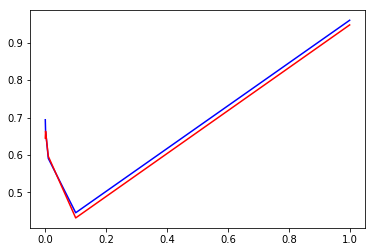

In [102]:
plt.figure()
plt.plot(regs,E_outs_unbiased,'blue')
plt.plot(regs,E_outs_biased,'red')

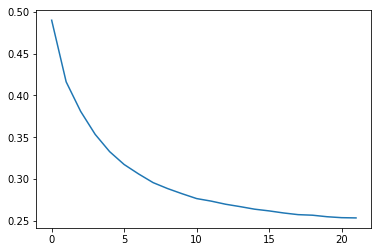

In [94]:
plt.figure()
plt.plot(np.arange(np.array(err_record2[1:]).size),np.array(err_record2[1:]))
#plt.plot(np.arange(np.array(err_reduc2[1:]).size),np.array(err_reduc2[1:]))

In [88]:
np.array(err_record2).size

20

In [87]:
np.array(err_reduc2)

array([1.00000000e+00, 1.23560584e-02, 5.86842637e-03, 3.83558842e-03,
       3.10505915e-03, 2.11505085e-03, 1.63411571e-03, 1.29529997e-03,
       1.08935058e-03, 6.92592817e-04, 7.57978153e-04, 4.90319161e-04,
       4.88532812e-04, 2.48639514e-04, 2.48844718e-04, 3.75683085e-04,
       1.36263220e-04, 2.09280834e-04, 5.48587110e-05])

In [101]:
a_bias[3]

array([[0.84073958],
       [1.09926119],
       [0.88682059],
       [1.93461177],
       [0.78596975],
       [0.7760698 ],
       [1.36060663],
       [1.04533705],
       [1.7389188 ],
       [1.36137934],
       [1.1460244 ],
       [1.38459218],
       [0.78245186],
       [1.23574523],
       [0.83900159],
       [1.19278826],
       [0.80626014],
       [1.01540487],
       [1.39803513],
       [1.02350322],
       [0.78131609],
       [0.80676585],
       [0.99210446],
       [1.34639563],
       [1.1906538 ],
       [0.76842956],
       [1.24294734],
       [1.09172519],
       [1.52747004],
       [1.48898792],
       [1.28143664],
       [1.05920841],
       [1.67774047],
       [1.75830416],
       [1.1300043 ],
       [2.06674322],
       [1.34886442],
       [1.45715447],
       [1.52400597],
       [1.08129074],
       [1.01732599],
       [0.94951371],
       [1.08911077],
       [0.99928239],
       [1.3301695 ],
       [1.54938974],
       [1.36731576],
       [0.988